In [1]:
# importing required libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
# read text file into pandas DataFrame
df = pd.read_csv("ParkingDataDataset.txt", sep="\t")

In [4]:
cleaned_df = df.copy()

# dropping useless columns
cleaned_df.drop('Car ID', inplace=True, axis=1)
cleaned_df.drop('Unnamed: 27', inplace=True, axis=1)
# cleaned_df.drop('VType', inplace=True, axis=1)

# dropping useless rows
cleaned_df.drop(cleaned_df[cleaned_df['tFree'] == 0].index, inplace = True)
cleaned_df.drop(cleaned_df[cleaned_df['EntMin'] == 60] .index, inplace = True)

In [5]:
# creating datetime index column
cleaned_df['datetime'] = cleaned_df.iloc[:, 0]
cleaned_df.datetime = pd.to_datetime(cleaned_df.datetime)
cleaned_df.set_index(cleaned_df.datetime)
print('Index Column Created!')

Index Column Created!


In [6]:
# Sorting the data
cleaned_df = cleaned_df.sort_values(by=['Day', 'EntHr'], ascending=[True, True])

In [7]:
# creating new dataframe for model input
bill_df = cleaned_df.drop(cleaned_df.loc[:, cleaned_df.columns != "TBill"], axis=1)
# bill_df['datetime'] = cleaned_df.datetime
bill_df.set_index(cleaned_df.datetime, inplace=True)
bill_df

,TBill
datetime,
2022-01-01 08:25:00,8
2022-01-01 08:25:00,39
2022-01-01 08:39:00,48
2022-01-01 08:55:00,21
2022-01-01 08:49:00,52
...,...
2022-01-07 19:39:00,18
2022-01-07 19:51:00,0
2022-01-07 19:55:00,0


In [8]:
# aggregate
ts = bill_df['TBill'].resample('H').sum()
ts = ts.to_frame()

<Axes: xlabel='datetime'>

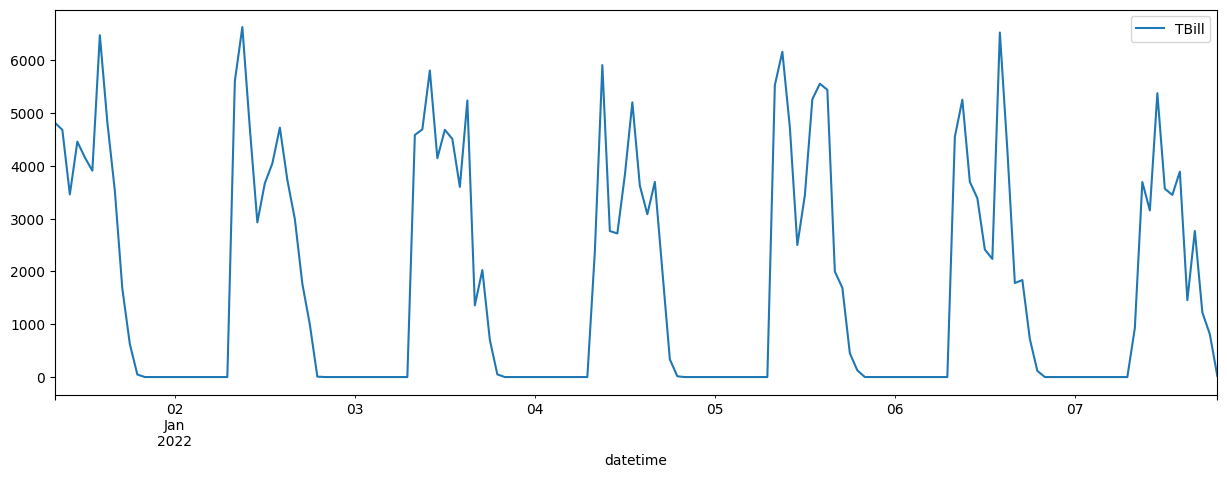

In [9]:
# plotting the aggregated series
ts.plot(figsize=(15, 5))

In [15]:
# SPLIT THE MAIN DATASET INTO TRAIN AND TEST DATASETS
# Determine the split point based on the desired ratio (80% train, 20% test)
split_ratio = 0.8
split_index = int(split_ratio * len(ts))

# Split the data into training and testing datasets
df_test = ts.iloc[split_index:]  # test set
ts = ts.iloc[:split_index]  # train set

In [16]:
# Testing For Stationarity
from statsmodels.tsa.stattools import adfuller

# Ho: It is non stationary
# H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

adfuller_test(ts)

ADF Test Statistic : -5.2200320517550605
p-value : 8.000820337180854e-06
#Lags Used : 12
Number of Observations Used : 86
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [17]:
new_ts = ts.copy()
new_ts

,TBill
datetime,
2022-01-01 08:00:00,4818
2022-01-01 09:00:00,4682
2022-01-01 10:00:00,3459
2022-01-01 11:00:00,4458
2022-01-01 12:00:00,4160
...,...
2022-01-05 06:00:00,0
2022-01-05 07:00:00,0
2022-01-05 08:00:00,5529


### Model

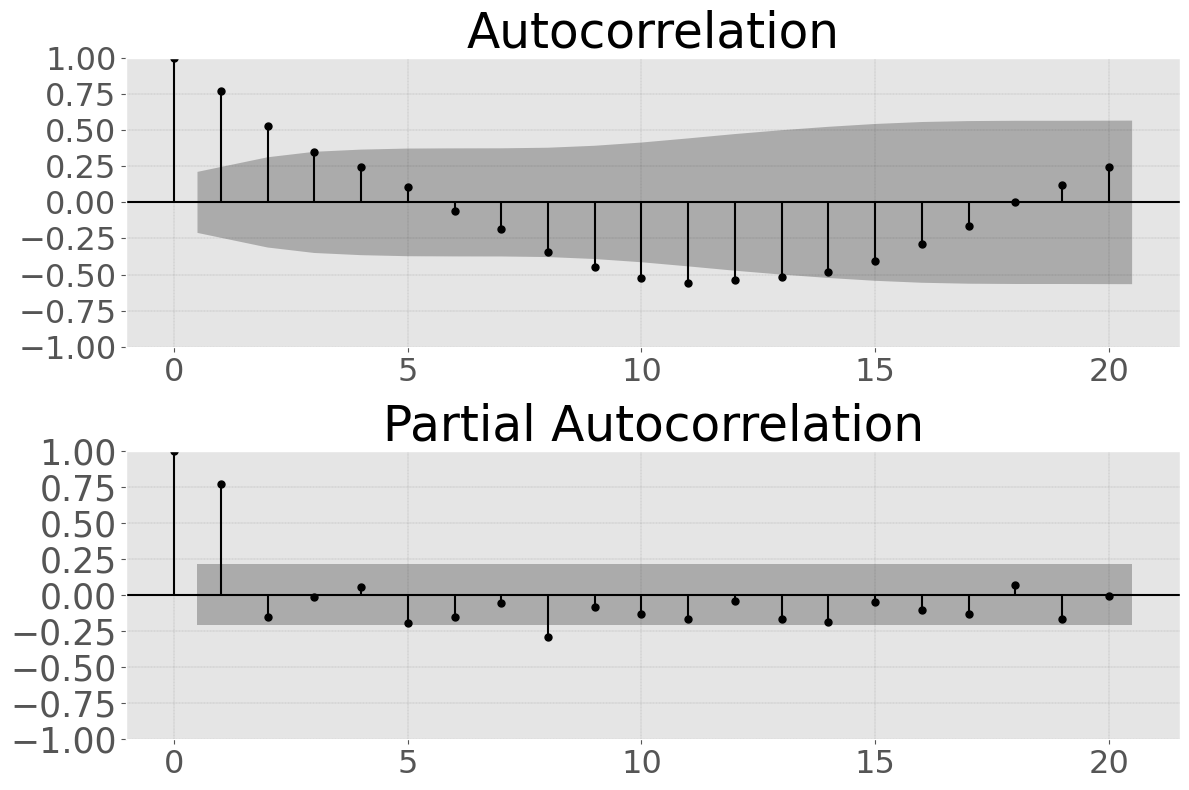

In [18]:
# selecting values of p and q
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from matplotlib.collections import PolyCollection

plt.style.use('ggplot')

my_color = 'black'

fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(new_ts.iloc[13:], ax=ax1, use_vlines=True, color=my_color, vlines_kwargs={"colors": my_color})

for item in ax1.collections:
    if type(item)==PolyCollection:
        item.set_facecolor(my_color)

ax1.grid(which="major", color="grey", linestyle="--", linewidth=0.20)
ax1.set_title("Autocorrelation", fontsize=35)

plt.yticks(fontsize=23)
plt.xticks(fontsize=23)

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(new_ts.iloc[13:], ax=ax2, use_vlines=True, color=my_color, vlines_kwargs={"colors": my_color})

# Customising the appearance
for item in ax2.collections:
    if type(item)==PolyCollection:
        item.set_facecolor(my_color)

ax2.grid(which="major", color="grey", linestyle="--", linewidth=0.20)
ax2.set_title("Partial Autocorrelation", fontsize=35)

plt.yticks(fontsize=25)
plt.xticks(fontsize=23)

fig.tight_layout()
plt.savefig('foo.png', bbox_inches='tight')

In [19]:
# fitting the model
model = sm.tsa.statespace.SARIMAX(ts['TBill'], order=(1,1,0), seasonal_order=(0,1,1,24))
results = model.fit()

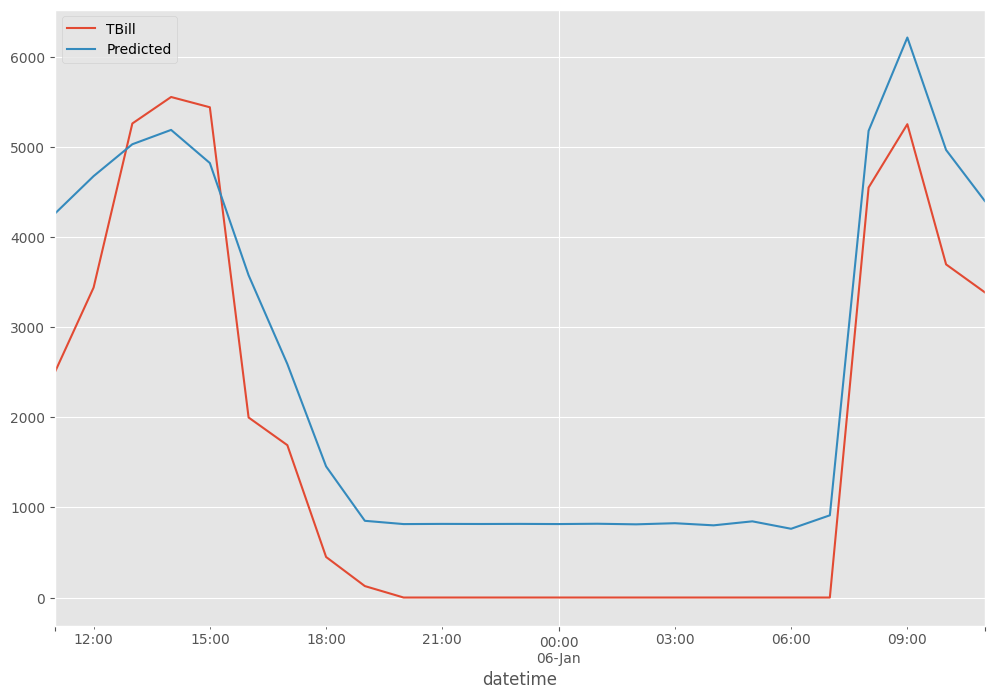

In [32]:
# getting evaluation on test set
predicted_ts = results.predict(df_test.index[0], df_test.index[-1])

# visualizing accuracy of the model on training data
df_test.plot(figsize=(12,8), label='Actual')
predicted_ts.plot(figsize=(12,8), label='Predicted')
plt.legend()
plt.show()

In [36]:
# Evaluation
rmse = np.sqrt(np.mean((np.array(predicted_ts).reshape(-1, 1) - np.array(df_test['TBill']).reshape(-1, 1))**2))
print(f"Score (RMSE): {rmse:.4f}")

Score (RMSE): 940.4470


### Extrapolating

In [26]:
# # The following code generates future timestamps after
# # the timestamp of last training sample present in out data
# # set, hence the aggregation of term 'new_ts.index[-1]' in 2nd line .

# # The value 0-29 in range suggest that we are extrapolating for next 29 hours, i.e., from
# # 7 July, 7 pm TO 8 July, 11:59 pm(29 hours)

# from pandas.tseries.offsets import DateOffset
# future_dates=[new_ts.index[-1]+ DateOffset(hours=x)for x in range(0,29)]
# future_dates

In [27]:
# # Converting above series to DataFrame
# future_datest_df=pd.DataFrame(index=future_dates[1:],columns=new_ts.columns)
# future_datest_df

In [28]:
# # Appending the above dataframe at the end of our original dataframe
# new_ts=pd.concat([new_ts,future_datest_df])
# (new_ts)

In [29]:
# # getting predictions
# new_ts['TBill'].iloc[156:183] = results.predict(start = 156, end = 182, dynamic= True)
# new_ts.TBill.plot(figsize=(12, 8))
# new_ts.head(30)

In [30]:
# import datetime
# plt.style.use('ggplot')

# # For Rolling Mean
# new_ts['RollingMean'] = new_ts.TBill.rolling(10).mean()
# sd = ts.TBill.std()
# mean = ts.TBill.mean()

# #Plotting predictions and the previous data
# fig, ax = plt.subplots(figsize=(12,8))
# xticks = pd.date_range(datetime.datetime(2022,1,1), datetime.datetime(2022,1,8), freq='d')

# new_ts.TBill.plot(ax=ax, figsize=(12,8), xticks=xticks.to_pydatetime(), color='#024ac7')
# new_ts.RollingMean.plot(ax=ax, figsize=(12,8), xticks=xticks.to_pydatetime(), color='g', alpha=1)

# # Customising appearance of plot
# ax.set_xticklabels([x.strftime('%d-%m-%y') for x in xticks]);
# for axis in ['top','bottom','left','right']:
#     ax.spines[axis].set_linewidth(2)
#     ax.spines[axis].set_color('black')

# for line in ax.yaxis.get_ticklines():
#     line.set_markersize(8)
#     line.set_markeredgewidth(3)
# for line in ax.xaxis.get_ticklines():
#     line.set_markersize(8)
#     line.set_markeredgewidth(3)
# ax.set_facecolor('white')


# plt.yticks(fontsize=18, color='black')
# plt.xticks(fontsize=18, color='black')
# plt.xlabel("Days(Time)", fontsize=24, color='black')
# plt.ylabel("Revenue", fontsize=24, color='black')

# leg = plt.legend(fontsize=18, loc = "upper right")
# for text in leg.get_texts():
#     text.set_color("black")
# plt.grid(alpha=0.2)
# plt.tight_layout()
# plt.xticks(rotation = 25)
# plt.grid(False)

# plt.savefig('predictions.png', bbox_inches='tight', format='png', facecolor='w')
# plt.show()